/home/jaxa/shintaro/SDF360/dataset/OmniBlender/barbershop/colmap/sparse/0


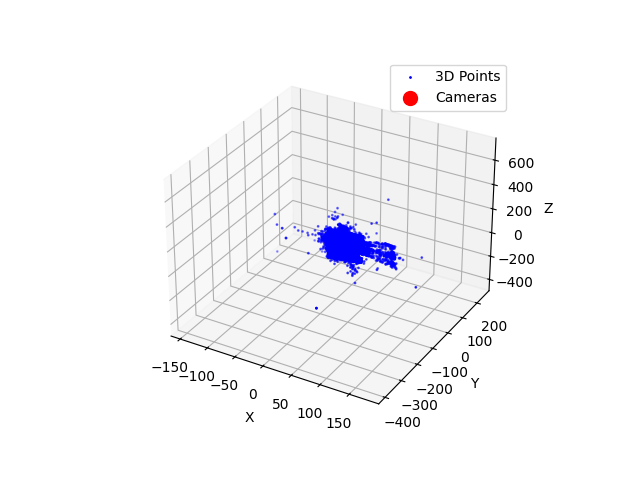

In [1]:
import os
import numpy as np
import pycolmap
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

# proj_dir = "/home/jaxa/shintaro/SDF360/dataset/DTU/scan9_colmap"
# proj_dir = "/home/jaxa/shintaro/SDF360/dataset/sdfstudio-demo-data/replica-room0/"
# proj_dir = "/home/jaxa/shintaro/SDF360/dataset/mp360_test/cathedral_new/colmap"
# proj_dir = "/home/jaxa/shintaro/SDF360/dataset/mp360_test/cathedral/colmap"
# proj_dir = "/home/jaxa/shintaro/SDF360/dataset/mp360_test/church_new/colmap"
# proj_dir = "/home/jaxa/shintaro/SDF360/dataset/mp360_test/church/colmap"
proj_dir = "/home/jaxa/shintaro/SDF360/dataset/OmniBlender/barbershop/colmap"

proj_dir = f"{proj_dir}/sparse/0"
print(proj_dir)
# Load COLMAP data using pycolmap
reconstruction = pycolmap.Reconstruction(proj_dir)

# Extract camera positions
camera_positions = np.array([reconstruction.images[k].cam_from_world.translation for k in reconstruction.images])

# Extract 3D points
points = np.array([reconstruction.points3D[k].xyz for k in reconstruction.points3D])

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='b', marker='o', s=1, label='3D Points')
ax.scatter(camera_positions[:, 0], camera_positions[:, 1], camera_positions[:, 2], c='r', marker='o', s=100, label='Cameras')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()


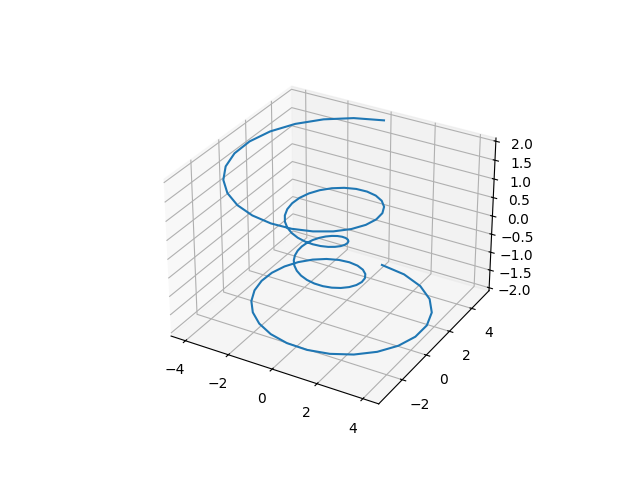

In [1]:
import numpy as np
theta = np.linspace(-4 * np.pi, 4 * np.pi, 100)
z = np.linspace(-2, 2, 100)
r = z**2 + 1
x = r * np.sin(theta)
y = r * np.cos(theta)

%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d    # <- 明示的には使わないが、インポートしておく必要がある。

fig = plt.figure()
ax = fig.add_subplot(projection='3d')    # <- axes3dをインポートしていないとエラーになる。
ax.plot(x, y, z)
plt.show()

In [13]:
import json
import numpy as np
import pycolmap

def convert_opensfm_to_colmap(opensfm_camera_file, opensfm_extrinsics_file, colmap_output_dir):
    # Load OpenSfM camera parameters
    with open(opensfm_camera_file, 'r') as f:
        opensfm_cameras = json.load(f)
    
    # Load OpenSfM extrinsics
    with open(opensfm_extrinsics_file, 'r') as f:
        opensfm_extrinsics = json.load(f)
    
    # Create COLMAP reconstruction object
    reconstruction = pycolmap.Reconstruction()
    
    # Convert cameras
    for cam_id, cam_params in opensfm_cameras.items():
        model = cam_params['projection_type']
        width = cam_params['width']
        height = cam_params['height']
        
        if model == 'perspective':
            params = cam_params['parameters']
            model_id = pycolmap.CameraModelId.SIMPLE_PINHOLE
            colmap_params = [params['focal'], width / 2, height / 2]
        elif model == 'brown':
            params = cam_params['parameters']
            model_id = pycolmap.CameraModelId.BROWN
            colmap_params = [
                params['focal_x'], params['focal_y'], params['c_x'], params['c_y'],
                params['k1'], params['k2'], params['p1'], params['p2'], params['k3']
            ]
        elif model == 'spherical':
            # spherical だとしても，perspective と同じとして扱う
            # model_id = pycolmap.CameraModel.SPHERICAL
            # colmap_params = []  # Spherical model does not require additional parameters
            model_id = pycolmap.CameraModelId.SIMPLE_PINHOLE
            colmap_params = [1.0, width / 2, height / 2]
        else:
            raise ValueError(f"Unsupported camera model: {model}")
        
        camera = pycolmap.Camera(model_id, width, height, colmap_params)
        reconstruction.add_camera(camera)
    
    # Convert extrinsics
    for img_id, extrinsics in opensfm_extrinsics.items():
        rotation = np.array(extrinsics['rotation'])
        translation = np.array(extrinsics['translation'])
        
        # Convert rotation matrix to quaternion
        quaternion = pycolmap.Rotation.from_matrix(rotation).as_quat()
        
        # Create COLMAP image object
        image = pycolmap.Image(
            id=int(img_id),
            camera_id=int(extrinsics['camera_id']),
            qvec=quaternion,
            tvec=translation,
            name=extrinsics['image_name']
        )
        reconstruction.add_image(image)
    
    # Save COLMAP reconstruction
    reconstruction.write(colmap_output_dir)

# Example usage
# proj_dir = '/home/jaxa/shintaro/SDF360/dataset/mp360_test/cathedral'
proj_dir = '/home/jaxa/shintaro/SDF360/dataset/DTU/scan9_opensfm'
opensfm_camera_file = f'{proj_dir}/camera_models.json'
opensfm_extrinsics_file = f'{proj_dir}/reconstruction.json'
colmap_output_dir = f'{proj_dir}/colmap/output'

convert_opensfm_to_colmap(opensfm_camera_file, opensfm_extrinsics_file, colmap_output_dir)

KeyError: 'parameters'